# MONAI 3D Detection using Spleen Dataset
- NOTE: This script requires a GPU with at least 16GB of VRAM To run.

This next cell will check to see if monai is installed, and if it isn't it will install it.

In [1]:
!python -c "import monai" || pip install -q "monai[gdown, nibabel, tqdm, ignite]==0.9.1"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'


# Imports

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    BoundingRectd,
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    CropForegroundd,
    Lambdad,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    ToTensord,
)
from monai.apps.detection.transforms.dictionary import (
    AffineBoxToImageCoordinated,
    AffineBoxToWorldCoordinated,
    BoxToMaskd,
    ClipBoxToImaged,
    ConvertBoxToStandardModed,
    MaskToBoxd,
    RandCropBoxByPosNegLabeld,
    RandFlipBoxd,
    RandRotateBox90d,
    RandZoomBoxd,
    ConvertBoxModed
)
from monai.apps.detection.utils.anchor_utils import AnchorGeneratorWithAnchorShape
from monai.apps.detection.metrics.coco import COCOMetric
from monai.apps.detection.metrics.matching import matching_batch
from monai.apps.detection.networks.retinanet_detector import RetinaNetDetector
from monai.apps.detection.networks.retinanet_network import (
    RetinaNet,
    resnet_fpn_feature_extractor,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import resnet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, box_utils
from monai.config import print_config
from monai.apps import download_and_extract
from monai.data.utils import no_collation
from warmup_scheduler import GradualWarmupScheduler
from visualize_image import visualize_one_xy_slice_in_3d_image
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tempfile
import shutil
import os
import glob
import time
import cv2
import gc

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Print MONAI and dependency versions

In [3]:
print_config()

MONAI version: 0.9.1
Numpy version: 1.22.4
Pytorch version: 1.13.0a0+08820cb
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.1
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.14.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Config and Hyperparameters

In [4]:
root_dir = "./"
amp = True
if amp:
    compute_dtype = torch.float16
else:
    compute_dtype = torch.float32

# Download Spleen Dataset

In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

# Enumerate the dataset and partition to train and validation

In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name, "label_class": np.array([0,])}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

# Transforms
1. Since our dataset contains segmentation labels rather than boxes, we will first load the standard segmentation transforms and ensure the nii.gz format images and labels are loaded correctly.
2. Next, we will call the MaskToBoxd function to create box coordinates from the label masks.
3. For training, we will also add random crops and zooms so that the images will fit into the training pipeline.

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        EnsureTyped(keys=["image"], dtype=torch.float32),
        EnsureTyped(keys="label_class", dtype=torch.long),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        MaskToBoxd(box_keys=["label_box"], label_keys=["label_class"], box_mask_keys=["label"], min_fg_label=0),
        RandCropBoxByPosNegLabeld(
            image_keys=["image"],
            box_keys="label_box",
            label_keys="label_class",
            spatial_size=[96,96,40],
            whole_box=True,
            num_samples=2,
            pos=1,
            neg=1,
        ),
        RandZoomBoxd(
            image_keys=["image"],
            box_keys=["label_box"],
            box_ref_image_keys=["image"],
            prob=0.2,
            min_zoom=0.7,
            max_zoom=1.4,
            padding_mode="constant",
            keep_size=True,
        ),
        EnsureTyped(keys=["image", "label_box"], dtype=compute_dtype),
        EnsureTyped(keys="label_class", dtype=torch.long),
        ToTensord(keys=["label_box", "label_class"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        EnsureTyped(keys=["image"], dtype=torch.float32),
        EnsureTyped(keys="label_class", dtype=torch.long),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        MaskToBoxd(box_keys=["label_box"], label_keys=["label_class"], box_mask_keys=["label"], min_fg_label=0),
        EnsureTyped(keys=["image", "label_box"], dtype=compute_dtype),
        EnsureTyped(keys="label_class", dtype=torch.long),
        ToTensord(keys=["label_box", "label_class"]),
    ]
)

# Check data
We can plot one sample using our validation transform to see what the data looks like after transformation

image shape: (228, 158, 113), label shape: (228, 158, 113), box: tensor([35., 54., 62., 78., 99., 93.], dtype=torch.float16), class: 0


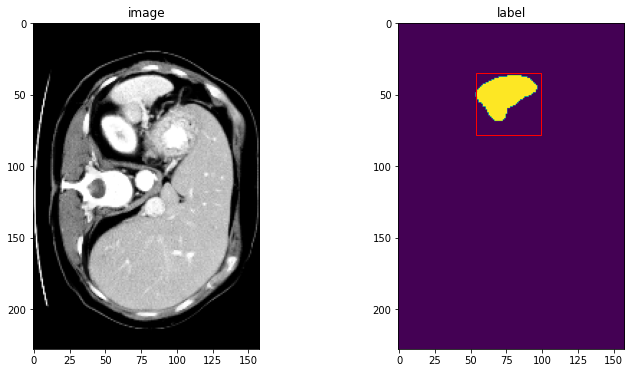

In [8]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1, collate_fn=no_collation)
check_data = first(check_loader)
image, label, box, label_class = (check_data[0]["image"][0], check_data[0]["label"][0], check_data[0]["label_box"][0], check_data[0]["label_class"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}, box: {box}, class: {label_class}")
# plot the slice [:, :, 80]
rect = patches.Rectangle((box[1], box[0]), box[4]-box[1], box[3]-box[0], linewidth=1, edgecolor='r', facecolor='none')
plt.figure("check", (12, 6))
ax = plt.subplot(1, 2, 1)
plt.title("image")
ax.imshow(image[:, :, 80], cmap="gray")
ax = plt.subplot(1, 2, 2)
plt.title("label")
ax.imshow(label[:, :, 80])
ax.add_patch(rect)
plt.show()

# Dataset and DataLoader
Since there aren't a lot of data in the spleen dataset, we can use the CacheDataset and preload everything into RAM.

In [9]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=no_collation)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=no_collation)

Loading dataset: 100%|██████████| 9/9 [00:21<00:00,  2.41s/it]


# Build Anchor Generator
For detection models, anchors generators are required to perform the detection.
- returned_layers: when target boxes are small, set it smaller
- base_anchor_shapes: anchor shape for the most high-resolution output, when target boxes are small, set it smaller

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

anchor_generator = AnchorGeneratorWithAnchorShape(
    feature_map_scales=[2**l for l in range(len([1,2]) + 1)],
    base_anchor_shapes=[[6,8,4],[8,6,5],[10,10,6]],
)

# Build Model Backbone and FPN
For detection models, we can then select the model backbone. Here, we choose to use a ResNet model as our backbone, connect it to a feature extractor which is a helper function that converts the ResNet into a FPN feature extractor, and then finally using the RetinaNet model and attaching the feature extractor to it.

In [10]:
conv1_t_size = [max(7, 2 * s + 1) for s in [2,2,1]]
backbone = resnet.ResNet(
    block=resnet.ResNetBottleneck,
    layers=[3, 4, 6, 3],
    block_inplanes=resnet.get_inplanes(),
    n_input_channels=1,
    conv1_t_stride=[2,2,1],
    conv1_t_size=conv1_t_size,
)
feature_extractor = resnet_fpn_feature_extractor(
    backbone=backbone,
    spatial_dims=3,
    pretrained_backbone=False,
    trainable_backbone_layers=None,
    returned_layers=[1,2],
)
num_anchors = anchor_generator.num_anchors_per_location()[0]
size_divisible = [
    s * 2 * 2 ** max([1,2])
    for s in feature_extractor.body.conv1.stride
]
#net = torch.jit.script(
net = RetinaNet(
        spatial_dims=3,
        num_classes=1,
        num_anchors=num_anchors,
        feature_extractor=feature_extractor,
        size_divisible=size_divisible,
    )
#)

# Build Detector
This next part we will attach the FPN to a detector. Then we set the different samplers, parameters, and inferers.

In [11]:
# 3) build detector
detector = RetinaNetDetector(
    network=net, anchor_generator=anchor_generator, debug=False
).to(device)

# set training components
detector.set_atss_matcher(num_candidates=4, center_in_gt=False)
detector.set_hard_negative_sampler(
    batch_size_per_image=64,
    positive_fraction=0.3,
    pool_size=20,
    min_neg=16,
)
detector.set_target_keys(box_key="label_box", label_key="label_class")

# set validation components
detector.set_box_selector_parameters(
    score_thresh=0.02,
    topk_candidates_per_level=1000,
    nms_thresh=0.22,
    detections_per_img=100,
)
detector.set_sliding_window_inferer(
    roi_size=[512,512,208],
    overlap=0.25,
    sw_batch_size=1,
    mode="constant",
    device="cpu",
)

# Optimizer
Here we use the SGD optimizer, and we will use a gradual warmup scaler that is written for PyTorch.

In [12]:
optimizer = torch.optim.SGD(
    detector.network.parameters(),
    1e-2,
    momentum=0.9,
    weight_decay=3e-5,
    nesterov=True,
)
after_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=10, after_scheduler=after_scheduler)
scaler = torch.cuda.amp.GradScaler()
optimizer.zero_grad()
optimizer.step()

# Train Model
Lastly, we perform the standard pytorch model training steps. In this example we also add a tensorboard writer to write logs that we can view on a tensorboard.

In [14]:
# initialize tensorboard writer
tensorboard_writer = SummaryWriter("./logs")

# 5. train
val_interval = 5  # do validation every val_interval epochs
coco_metric = COCOMetric(classes=["spleen"], iou_list=[0.1], max_detection=[100])
best_val_epoch_metric = 0.0
best_val_epoch = -1  # the epoch that gives best validation metrics
max_epochs = 25
epoch_len = len(train_ds) // train_loader.batch_size
w_cls = 1.0  # weight between classification loss and box regression loss, default 1.0
for epoch in range(max_epochs):
    # ------------- Training -------------
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    detector.train()
    epoch_loss = 0
    epoch_cls_loss = 0
    epoch_box_reg_loss = 0
    step = 0
    start_time = time.time()
    scheduler_warmup.step()
    # Training
    for batch_data in train_loader:
        step += 1
        inputs = [
            batch_data_ii["image"].to(device)
            for batch_data_i in batch_data
            for batch_data_ii in batch_data_i
        ]
        targets = [
            dict(
                label_class=batch_data_ii["label_class"].to(device),
                label_box=batch_data_ii["label_box"].to(device),
            )
            for batch_data_i in batch_data
            for batch_data_ii in batch_data_i
        ]

        for param in detector.network.parameters():
            param.grad = None

        if amp and (scaler is not None):
            with torch.cuda.amp.autocast():
                outputs = detector(inputs, targets)
                loss = (
                    w_cls * outputs[detector.cls_key]
                    + outputs[detector.box_reg_key]
                )
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = detector(inputs, targets)
            loss = w_cls * outputs[detector.cls_key] + outputs[detector.box_reg_key]
            loss.backward()
            optimizer.step()

        # save to tensorboard
        epoch_loss += loss.detach().item()
        epoch_cls_loss += outputs[detector.cls_key].detach().item()
        epoch_box_reg_loss += outputs[detector.box_reg_key].detach().item()
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        tensorboard_writer.add_scalar(
            "train_loss", loss.detach().item(), epoch_len * epoch + step
        )

    end_time = time.time()
    print(f"Training time: {end_time-start_time}s")
    del inputs, batch_data
    torch.cuda.empty_cache()
    gc.collect()

    # save to tensorboard
    epoch_loss /= step
    epoch_cls_loss /= step
    epoch_box_reg_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    tensorboard_writer.add_scalar("avg_train_loss", epoch_loss, epoch + 1)
    tensorboard_writer.add_scalar("avg_train_cls_loss", epoch_cls_loss, epoch + 1)
    tensorboard_writer.add_scalar(
        "avg_train_box_reg_loss", epoch_box_reg_loss, epoch + 1
    )
    tensorboard_writer.add_scalar(
        "train_lr", optimizer.param_groups[0]["lr"], epoch + 1
    )

    # save last trained model
    #torch.jit.save(detector.network,"./model_last.pt")
    torch.save(detector.network.state_dict(), "./model_last.pth")
    print("saved last model")

    # ------------- Validation for model selection -------------
    if (epoch + 1) % val_interval == 0:
        detector.eval()
        val_outputs_all = []
        val_targets_all = []
        start_time = time.time()
        with torch.no_grad():
            for val_data in val_loader:
                use_inferer = True
                val_inputs = [
                    val_data_i.pop("image").to(device) for val_data_i in val_data
                ]

                if amp:
                    with torch.cuda.amp.autocast():
                        val_outputs = detector(val_inputs, use_inferer=use_inferer)
                else:
                    val_outputs = detector(val_inputs, use_inferer=use_inferer)

                # save outputs for evaluation
                val_outputs_all += val_outputs
                val_targets_all += val_data

        end_time = time.time()
        print(f"Validation time: {end_time-start_time}s")

        # visualize an inference image and boxes to tensorboard
        draw_img = visualize_one_xy_slice_in_3d_image(
            gt_boxes=val_data[0]["label_box"].cpu().detach().numpy(),
            image=val_inputs[0][0, ...].cpu().detach().numpy(),
            pred_boxes=val_outputs[0][detector.target_box_key]
            .cpu()
            .detach()
            .numpy(),
        )
        tensorboard_writer.add_image(
            "val_img_xy", draw_img.transpose([2, 1, 0]), epoch + 1
        )

        # compute metrics
        del val_inputs
        torch.cuda.empty_cache()
        results_metric = matching_batch(
            iou_fn=box_utils.box_iou,
            iou_thresholds=coco_metric.iou_thresholds,
            pred_boxes=[
                val_data_i[detector.target_box_key].cpu().detach().numpy()
                for val_data_i in val_outputs_all
            ],
            pred_classes=[
                val_data_i[detector.target_label_key].cpu().detach().numpy()
                for val_data_i in val_outputs_all
            ],
            pred_scores=[
                val_data_i[detector.pred_score_key].cpu().detach().numpy()
                for val_data_i in val_outputs_all
            ],
            gt_boxes=[
                val_data_i[detector.target_box_key].cpu().detach().numpy()
                for val_data_i in val_targets_all
            ],
            gt_classes=[
                val_data_i[detector.target_label_key].cpu().detach().numpy()
                for val_data_i in val_targets_all
            ],
        )
        val_epoch_metric_dict = coco_metric(results_metric)[0]
        print(val_epoch_metric_dict)

        # write to tensorboard event
        for k in val_epoch_metric_dict.keys():
            tensorboard_writer.add_scalar(
                "val_" + k, val_epoch_metric_dict[k], epoch + 1
            )
        val_epoch_metric = val_epoch_metric_dict.values()
        val_epoch_metric = sum(val_epoch_metric) / len(val_epoch_metric)
        tensorboard_writer.add_scalar("val_metric", val_epoch_metric, epoch + 1)

        # save best trained model
        if val_epoch_metric > best_val_epoch_metric:
            best_val_epoch_metric = val_epoch_metric
            best_val_epoch = epoch + 1
            #torch.jit.save(detector.network, "model_best.pt")
            torch.save(detector.network.state_dict(), "./model_best.pth")
            print("saved new best metric model")
        print(
            "current epoch: {} current metric: {:.4f} "
            "best metric: {:.4f} at epoch {}".format(
                epoch + 1, val_epoch_metric, best_val_epoch_metric, best_val_epoch
            )
        )

print(
    f"train completed, best_metric: {best_val_epoch_metric:.4f} "
    f"at epoch: {best_val_epoch}"
)
tensorboard_writer.close()

----------
epoch 1/25
1/16, train_loss: 1.3887
2/16, train_loss: 1.1553
3/16, train_loss: 1.1348
4/16, train_loss: 1.2344
5/16, train_loss: 0.0349
6/16, train_loss: 1.4951
7/16, train_loss: 1.0059
8/16, train_loss: 1.3877
9/16, train_loss: 1.3242
10/16, train_loss: 1.2891
11/16, train_loss: 0.6982
12/16, train_loss: 0.9092
13/16, train_loss: 1.6934
14/16, train_loss: 1.2734
15/16, train_loss: 0.7827
16/16, train_loss: 1.2246
Training time: 10.958168983459473s
epoch 1 average loss: 1.1270
saved last model
----------
epoch 2/25
1/16, train_loss: 0.9688
2/16, train_loss: 1.6426
3/16, train_loss: 1.6641
4/16, train_loss: 1.1514
5/16, train_loss: 1.4209
6/16, train_loss: 0.1564
7/16, train_loss: 1.2734
8/16, train_loss: 0.9365
9/16, train_loss: 1.1895
10/16, train_loss: 0.9219
11/16, train_loss: 1.2422
12/16, train_loss: 1.4346
13/16, train_loss: 1.7783
14/16, train_loss: 0.9741
15/16, train_loss: 1.2383
16/16, train_loss: 1.0166
Training time: 8.373231887817383s
epoch 2 average loss: 1.188

# Load Best Model

In [13]:
detector.network.load_state_dict(torch.load("./model_best.pth"))

<All keys matched successfully>

In [14]:
sample_data = [i["image"].to(device) for i in check_data]

In [15]:
detector.eval()
with torch.no_grad():
    with torch.cuda.amp.autocast():
        x = detector(sample_data, use_inferer=True)

In [16]:
draw_img = visualize_one_xy_slice_in_3d_image(
    gt_boxes=check_data[0]["label_box"].cpu().detach().numpy(),
    image=[i["image"].to(device) for i in check_data][0][0, ...].cpu().detach().numpy(),
    pred_boxes=x[0]["label_box"].cpu().detach().numpy(),
)

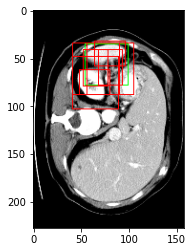

In [17]:
plt.imshow(draw_img)

# Save as ONNX for TensorRT and Triton

In [18]:
onnx_model = torch.onnx.export(detector.network,
   args=torch.tensor([sample_data[0].array], dtype=torch.float32).to(device),
   f='model.onnx',
   input_names=["input"],
   output_names=["cls_head", "box_head"],
   dynamic_axes={'input': [0,2,3,4], 'cls_head': {0: 'batch'}, 'box_head': {0: 'batch'}})

/tmp/ipykernel_48383/3894814226.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:229.)
  args=torch.tensor([sample_data[0].array], dtype=torch.float32).to(device),
/opt/conda/lib/python3.8/site-packages/torch/onnx/utils.py:1864: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/monai/apps/detection/networks/retinanet_network.py:125: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if to

# Save as Torchscript for MONAI Deploy

In [21]:
torch.jit.script(detector.network).save("classifier.zip")

# Free Memory

In [ ]:
import os
os._exit(00)